# Sistem Prediksi Risiko Kredit Nasabah Menggunakan Neural Network dan Transfer Learning pada Data Tabular



## Import library

In [ ]:
!pip install rtdl_revisiting_models

In [ ]:
# ============================================================
# BASIC UTILITIES
# ============================================================
import os
import random
import warnings
warnings.filterwarnings("ignore")

# Reproducibility
import numpy as np
import pandas as pd

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# ============================================================
# DATA VISUALIZATION (EDA)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (8, 5)

# ============================================================
# DATA PREPROCESSING
# ============================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ============================================================
# MODEL EVALUATION
# ============================================================
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# ============================================================
# NEURAL NETWORK BASE (MLP)
# ============================================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping
from torch.utils.data import TensorDataset, DataLoader


In [ ]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.8 MB/s eta 0:00:00


In [ ]:
# ============================================================
# TABNET (TRANSFER LEARNING - TABULAR)
# ============================================================


import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from rtdl_revisiting_models import FTTransformer
from torch import nn

# # ============================================================
# # TABNET (TRANSFER LEARNING - TABULAR)
# # ============================================================
# !pip install pytorch-tabnet

# import torch
# from pytorch_tabnet.tab_model import TabNetClassifier

# ============================================================
# DEVICE CONFIGURATION
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


## Load dataset

In [ ]:
# ============================================================
# LOAD DATASET
# ============================================================

DATA_PATH = "/content/credit_risk_dataset.csv"

# Load dataset
df = pd.read_csv(DATA_PATH)

# ============================================================
# BASIC DATA CHECK
# ============================================================

print("Dataset berhasil dimuat ✅")
print(f"Jumlah data  : {df.shape[0]:,} baris")
print(f"Jumlah fitur : {df.shape[1]} kolom")

# Tampilkan 5 data pertama
df.head()


Dataset berhasil dimuat ✅
Jumlah data  : 32,581 baris
Jumlah fitur : 12 kolom


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


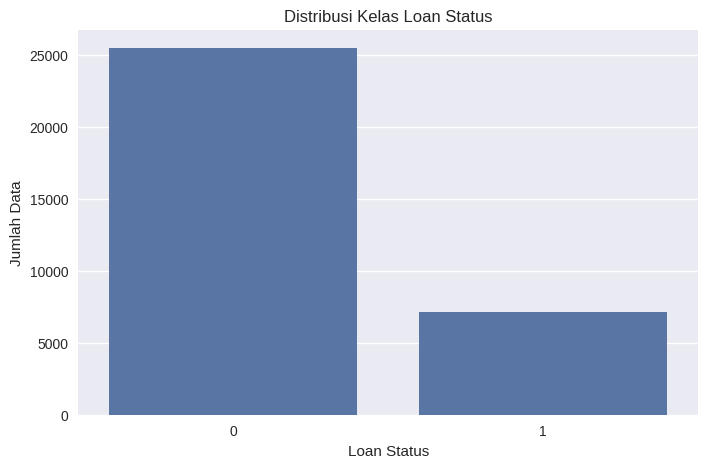

Jumlah fitur numerik      : 7
Jumlah fitur kategorikal  : 4

Fitur Kategorikal:


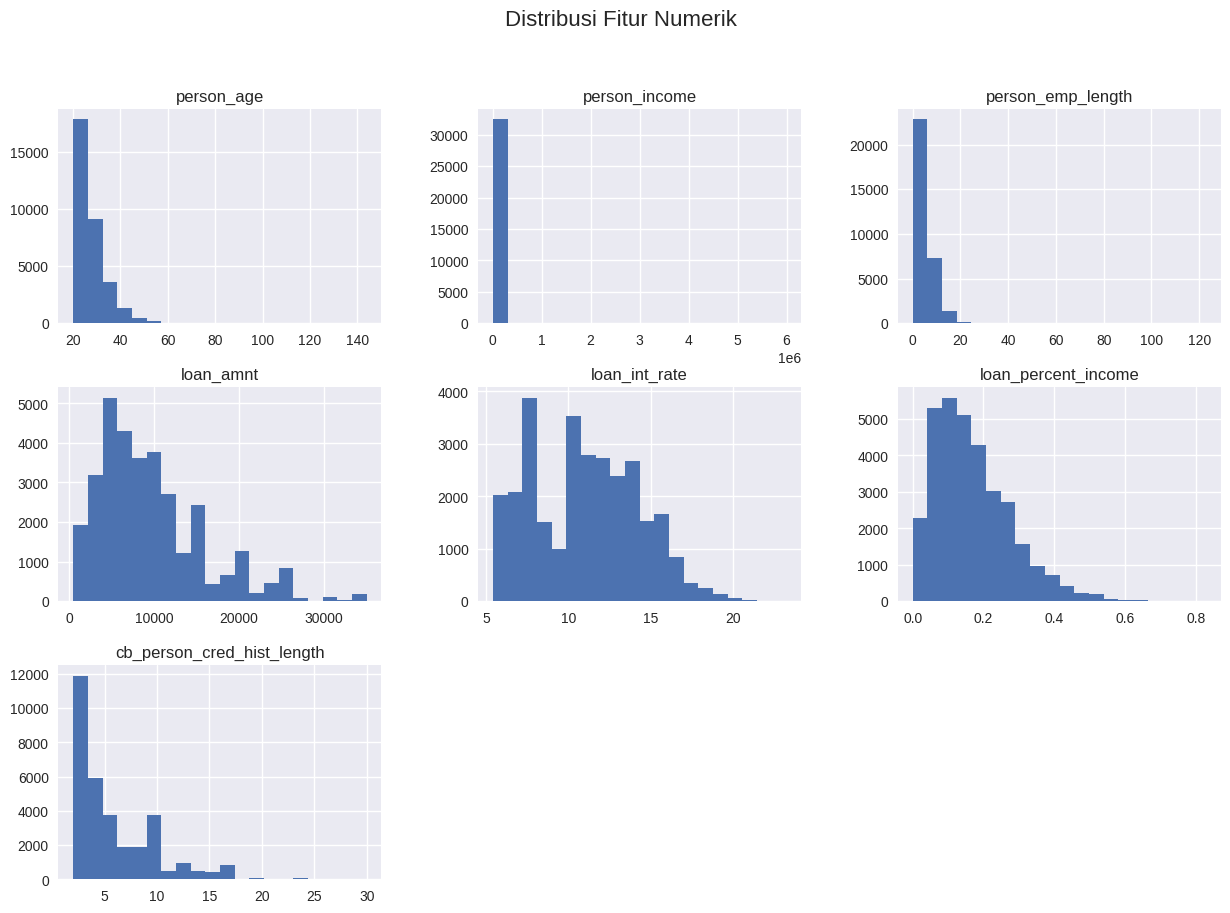

In [ ]:
# ============================================================
# BASIC DATA INFORMATION
# ============================================================

df.info()

# ============================================================
# DESCRIPTIVE STATISTICS
# ============================================================

df.describe().T

# ============================================================
# TARGET DISTRIBUTION
# ============================================================

TARGET_COL = "loan_status"

df[TARGET_COL].value_counts()

# ============================================================
# TARGET DISTRIBUTION PLOT
# ============================================================

sns.countplot(
    x=TARGET_COL,
    data=df
)
plt.title("Distribusi Kelas Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Jumlah Data")
plt.show()

# ============================================================
# MISSING VALUES CHECK
# ============================================================

missing_df = (
    df.isnull()
      .sum()
      .sort_values(ascending=False)
)

missing_percentage = (missing_df / len(df)) * 100

missing_summary = pd.DataFrame({
    "Missing Count": missing_df,
    "Missing (%)": missing_percentage
})

missing_summary[missing_summary["Missing Count"] > 0]

# ============================================================
# FEATURE TYPE IDENTIFICATION
# ============================================================

categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Remove target from feature list
numerical_features.remove(TARGET_COL)

print(f"Jumlah fitur numerik      : {len(numerical_features)}")
print(f"Jumlah fitur kategorikal  : {len(categorical_features)}")

print("\nFitur Kategorikal:")
categorical_features

# ============================================================
# NUMERICAL FEATURE DISTRIBUTION
# ============================================================

df[numerical_features].hist(
    bins=20,
    figsize=(15, 10)
)
plt.suptitle("Distribusi Fitur Numerik", fontsize=16)
plt.show()


## Data preprocessing

In [ ]:
# ============================================================
# DEFINE TARGET & FEATURES
# ============================================================

TARGET_COL = "loan_status"

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print("Shape X:", X.shape)
print("Shape y:", y.shape)

# ============================================================
# FEATURE GROUPS (FROM EDA)
# ============================================================

numerical_features = [
    'person_age',
    'person_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length'
]

categorical_features = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file'
]

# ============================================================
# STRATIFIED SPLIT
# ============================================================

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("Train :", X_train.shape)
print("Val   :", X_val.shape)
print("Test  :", X_test.shape)








Shape X: (32581, 11)
Shape y: (32581,)
Train : (22806, 11)
Val   : (4887, 11)
Test  : (4888, 11)


### MLP Preprocessing

In [ ]:
# ============================================================
# PREPROCESSING PIPELINE - MLP
# ============================================================

numeric_mlp = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_mlp = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])

preprocessor_mlp = ColumnTransformer([
    ("num", numeric_mlp, numerical_features),
    ("cat", categorical_mlp, categorical_features)
])

X_train_mlp = preprocessor_mlp.fit_transform(X_train)
X_val_mlp   = preprocessor_mlp.transform(X_val)
X_test_mlp  = preprocessor_mlp.transform(X_test)


print("MLP input shape:", X_train_mlp.shape)

MLP input shape: (22806, 11)


### Tabnet Preprocessing

In [ ]:
# ============================================================
# PREPROCESSING PIPELINE - TABNET & EMBEDDING MODEL
# ============================================================

numeric_tab = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_tab = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])

preprocessor_tab = ColumnTransformer([
    ("num", numeric_tab, numerical_features),
    ("cat", categorical_tab, categorical_features)
])

X_train_tab = preprocessor_tab.fit_transform(X_train)
X_val_tab   = preprocessor_tab.transform(X_val)
X_test_tab  = preprocessor_tab.transform(X_test)

print("Tabnet input shape:", X_train_tab.shape)

Tabnet input shape: (22806, 11)


### FT-transformer Preprocessing

In [ ]:
num_cols = numerical_features
cat_cols = categorical_features
num_classes = y.nunique()

X_train_ft = X_train.copy()
X_val_ft   = X_val.copy()
X_test_ft  = X_test.copy()

# ===== CATEGORICAL =====
cat_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_train_ft[col] = le.fit_transform(X_train_ft[col].astype(str))
    X_val_ft[col]   = le.transform(X_val_ft[col].astype(str))
    X_test_ft[col]  = le.transform(X_test_ft[col].astype(str))
    cat_encoders[col] = le

# ===== NUMERICAL =====
num_imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_ft[num_cols] = scaler.fit_transform(
    num_imputer.fit_transform(X_train_ft[num_cols])
)
X_val_ft[num_cols] = scaler.transform(
    num_imputer.transform(X_val_ft[num_cols])
)
X_test_ft[num_cols] = scaler.transform(
    num_imputer.transform(X_test_ft[num_cols])
)


print("FT-Transformer input shape:", X_train_ft.shape)
print("Num features:", len(num_cols))
print("Cat features:", len(cat_cols))


FT-Transformer input shape: (22806, 11)
Num features: 7
Cat features: 4


## 🔵 Implementasi Model 1 – Neural Network Base (MLP)

### Arsitektur MLP & Compile Model

In [ ]:
# ============================================================
# ENSURE SAVE DIRECTORY EXISTS
# ============================================================
os.makedirs("artifacts", exist_ok=True)


# ============================================================
# MLP MODEL (NN BASE)
# ============================================================
mlp_model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_mlp.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation="relu"),
    Dropout(0.2),

    Dense(1, activation="sigmoid")
])

# ============================================================
# COMPILE MODEL
# ============================================================
mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc")
    ]
)

mlp_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,673 (49.50 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 384 (1.50 KB)

### Callback & Training Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



# ============================================================
# CALLBACKS
# ============================================================
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath="artifacts/mlp_model.keras",  # ✅ WAJIB .keras
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        verbose=1
    )
]


# ============================================================
# TRAINING
# ============================================================
history = mlp_model.fit(
    X_train_mlp,
    y_train,
    validation_data=(X_val_mlp, y_val),
    epochs=50,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6537 - auc: 0.7290 - loss: 0.6453
Epoch 1: val_auc improved from -inf to 0.86703, saving model to artifacts/mlp_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.6548 - auc: 0.7295 - loss: 0.6437 - val_accuracy: 0.8535 - val_auc: 0.8670 - val_loss: 0.3889
Epoch 2/50
79/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8360 - auc: 0.8323 - loss: 0.3884
Epoch 2: val_auc improved from 0.86703 to 0.87541, saving model to artifacts/mlp_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8365 - auc: 0.8333 - loss: 0.3876 - val_accuracy: 0.8570 - val_auc: 0.8754 - val_loss: 0.3457
Epoch 3/50
78/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8513 - auc: 0.8545 - loss: 0.3679
Epoch 3: val_auc improved from 0.87541 to 0.88157, saving model to artifacts/mlp_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8517 - auc: 0.8540 - loss: 0.3676 - val_accuracy: 0.8586 - val_auc: 0.8816 - val_

### Evaluasi MLP test set

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

  No Default       0.91      0.98      0.95      3821
     Default       0.91      0.67      0.77      1067

    accuracy                           0.91      4888
   macro avg       0.91      0.82      0.86      4888
weighted avg       0.91      0.91      0.91      4888



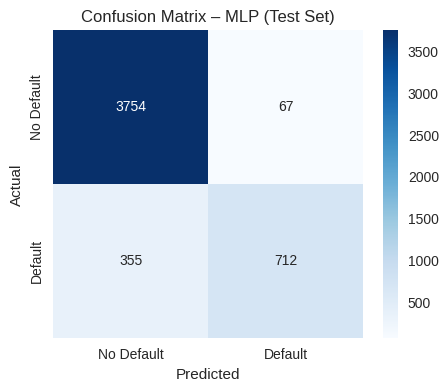

In [ ]:
import numpy as np

# Prediksi probabilitas
y_pred_proba = mlp_model.predict(X_test_mlp).ravel()

# Threshold default 0.5
y_pred = (y_pred_proba >= 0.5).astype(int)

from sklearn.metrics import classification_report

print(
    classification_report(
        y_test,
        y_pred,
        target_names=["No Default", "Default"]
    )
)


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Default", "Default"],
    yticklabels=["No Default", "Default"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – MLP (Test Set)")
plt.show()


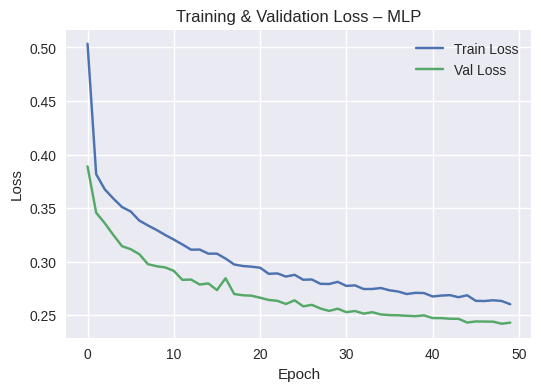

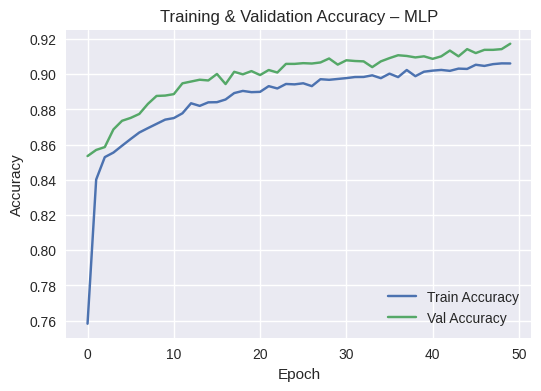

In [ ]:
# Loss
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss – MLP")
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy – MLP")
plt.legend()
plt.show()


### Save model

In [ ]:
# ============================================================
# SAVE MODEL & PREPROCESSOR (FOR STREAMLIT DEPLOYMENT)
# ============================================================

import os
import joblib

# ======================
# DIRECTORY SETUP
# ======================

SAVE_DIR = "/content/mlp_credit_risk_model"
os.makedirs(SAVE_DIR, exist_ok=True)

# ======================
# SAVE KERAS MODEL
# ======================

MODEL_PATH = os.path.join(SAVE_DIR, "mlp_model.h5")
mlp_model.save(MODEL_PATH)

print(f"✅ MLP model saved to: {MODEL_PATH}")

# ======================
# SAVE PREPROCESSOR
# ======================

PREPROCESSOR_PATH = os.path.join(SAVE_DIR, "preprocessor_mlp.pkl")
joblib.dump(preprocessor_mlp, PREPROCESSOR_PATH)

print(f"✅ Preprocessor saved to: {PREPROCESSOR_PATH}")

# ======================
# SAVE METADATA (OPTIONAL BUT RECOMMENDED)
# ======================

metadata = {
    "model_name": "MLP Credit Risk Classifier",
    "target_column": TARGET_COL,
    "numerical_features": numerical_features,
    "categorical_features": categorical_features,
    "decision_threshold": 0.5,
    "problem_type": "binary_classification"
}

METADATA_PATH = os.path.join(SAVE_DIR, "metadata.pkl")
joblib.dump(metadata, METADATA_PATH)

print(f"✅ Metadata saved to: {METADATA_PATH}")

# ======================
# SUMMARY
# ======================

print("\n📦 Saved files:")
for file in os.listdir(SAVE_DIR):
    print(" -", file)

✅ MLP model saved to: /content/mlp_credit_risk_model/mlp_model.h5
✅ Preprocessor saved to: /content/mlp_credit_risk_model/preprocessor_mlp.pkl
✅ Metadata saved to: /content/mlp_credit_risk_model/metadata.pkl

📦 Saved files:
 - mlp_model.h5
 - metadata.pkl
 - preprocessor_mlp.pkl


In [ ]:
!zip -r mlp_credit_risk_model.zip mlp_credit_risk_model


  adding: mlp_credit_risk_model/ (stored 0%)
  adding: mlp_credit_risk_model/mlp_model.h5 (deflated 29%)
  adding: mlp_credit_risk_model/metadata.pkl (deflated 35%)
  adding: mlp_credit_risk_model/preprocessor_mlp.pkl (deflated 62%)


## 🔵 Implementasi Model 2 - TabNet

### Tabnet Data preparation & Definition

In [ ]:
# ============================================================
# TABNET - DATA PREPARATION
# ============================================================

import numpy as np

X_train_tabnet = X_train_tab.astype(np.float32)
X_val_tabnet   = X_val_tab.astype(np.float32)
X_test_tabnet  = X_test_tab.astype(np.float32)

y_train_tabnet = y_train.values
y_val_tabnet   = y_val.values
y_test_tabnet  = y_test.values

print("TabNet Train Shape:", X_train_tabnet.shape)

# ============================================================
# TABNET MODEL DEFINITION
# ============================================================

from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_model = TabNetClassifier(
    n_d=16,              # dimension of decision prediction layer
    n_a=16,              # dimension of attention layer
    n_steps=5,           # number of sequential attention steps
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type="entmax",  # sparse attention
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=10
)


TabNet Train Shape: (22806, 11)


### Training Model

In [ ]:
# ============================================================
# TABNET TRAINING
# ============================================================

tabnet_model.fit(
    X_train=X_train_tabnet,
    y_train=y_train_tabnet,
    eval_set=[
        (X_train_tabnet, y_train_tabnet),
        (X_val_tabnet, y_val_tabnet)
    ],
    eval_name=["train", "val"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=15,          # early stopping
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


epoch 0  | loss: 0.53887 | train_accuracy: 0.51662 | val_accuracy: 0.51095 |  0:00:02s
epoch 10 | loss: 0.30427 | train_accuracy: 0.82316 | val_accuracy: 0.82791 |  0:00:24s
epoch 20 | loss: 0.28239 | train_accuracy: 0.87047 | val_accuracy: 0.87395 |  0:00:47s
epoch 30 | loss: 0.2572  | train_accuracy: 0.907   | val_accuracy: 0.90669 |  0:01:09s
epoch 40 | loss: 0.24984 | train_accuracy: 0.91669 | val_accuracy: 0.91631 |  0:01:31s
epoch 50 | loss: 0.24587 | train_accuracy: 0.9166  | val_accuracy: 0.91283 |  0:01:54s
epoch 60 | loss: 0.24304 | train_accuracy: 0.92063 | val_accuracy: 0.91938 |  0:02:16s

Early stopping occurred at epoch 61 with best_epoch = 46 and best_val_accuracy = 0.92122


### Evaluasi Tabnet Model

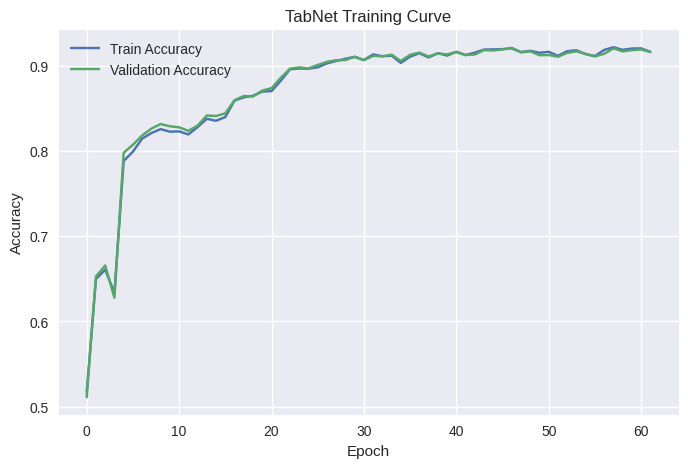

In [ ]:
# ============================================================
# TABNET TRAINING CURVE
# ============================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(tabnet_model.history["train_accuracy"], label="Train Accuracy")
plt.plot(tabnet_model.history["val_accuracy"], label="Validation Accuracy")
plt.title("TabNet Training Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ============================================================
# TABNET EVALUATION (TEST SET)
# ============================================================

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_test_pred_tabnet = tabnet_model.predict(X_test_tabnet)

print("Accuracy:", accuracy_score(y_test_tabnet, y_test_pred_tabnet))
print("\nClassification Report:\n")
print(classification_report(y_test_tabnet, y_test_pred_tabnet))

confusion_matrix(y_test_tabnet, y_test_pred_tabnet)


Accuracy: 0.9210310965630114

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3821
           1       0.95      0.68      0.79      1067

    accuracy                           0.92      4888
   macro avg       0.93      0.83      0.87      4888
weighted avg       0.92      0.92      0.92      4888



array([[3781,   40],
       [ 346,  721]])

In [ ]:
print(tabnet_model.history.history.keys())


dict_keys(['loss', 'lr', 'train_accuracy', 'val_accuracy'])


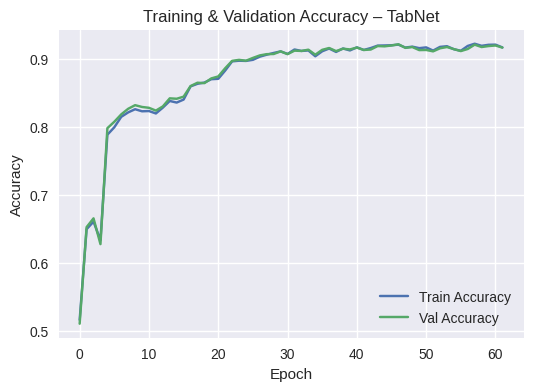

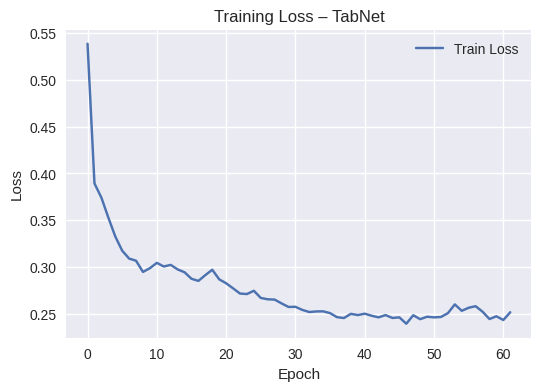

In [ ]:
# ============================================================
# TABNET TRAINING & VALIDATION ACCURACY
# ============================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(tabnet_model.history["train_accuracy"], label="Train Accuracy")
plt.plot(tabnet_model.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy – TabNet")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# TABNET TRAINING & VALIDATION LOSS
# ============================================================

plt.figure(figsize=(6, 4))
plt.plot(tabnet_model.history["loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss – TabNet")
plt.legend()
plt.grid(True)
plt.show()


### Save Model

In [ ]:
# ============================================================
# SAVE TABNET MODEL & PREPROCESSOR (FOR STREAMLIT)
# ============================================================

import os
import joblib

# ======================
# DIRECTORY SETUP
# ======================

SAVE_DIR = "/content/tabnet_credit_risk_model"
MODEL_DIR = os.path.join(SAVE_DIR, "tabnet_model")

os.makedirs(MODEL_DIR, exist_ok=True)

# ======================
# SAVE TABNET MODEL
# ======================

tabnet_model.save_model(os.path.join(MODEL_DIR, "model"))

print(f"✅ TabNet model saved to: {MODEL_DIR}")

# ======================
# SAVE PREPROCESSOR
# ======================

PREPROCESSOR_PATH = os.path.join(SAVE_DIR, "preprocessor_tab.pkl")
joblib.dump(preprocessor_tab, PREPROCESSOR_PATH)

print(f"✅ Preprocessor saved to: {PREPROCESSOR_PATH}")

# ======================
# SAVE METADATA
# ======================

metadata = {
    "model_name": "TabNet Credit Risk Classifier",
    "model_type": "tabnet",
    "target_column": TARGET_COL,
    "numerical_features": numerical_features,
    "categorical_features": categorical_features,
    "decision_threshold": 0.5,
    "problem_type": "binary_classification"
}

METADATA_PATH = os.path.join(SAVE_DIR, "metadata.pkl")
joblib.dump(metadata, METADATA_PATH)

print(f"✅ Metadata saved to: {METADATA_PATH}")

# ======================
# SUMMARY
# ======================

print("\n📦 Saved files:")
for root, dirs, files in os.walk(SAVE_DIR):
    level = root.replace(SAVE_DIR, "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    for f in files:
        print(f"{indent}    {f}")


Successfully saved model at /content/tabnet_credit_risk_model/tabnet_model/model.zip
✅ TabNet model saved to: /content/tabnet_credit_risk_model/tabnet_model
✅ Preprocessor saved to: /content/tabnet_credit_risk_model/preprocessor_tab.pkl
✅ Metadata saved to: /content/tabnet_credit_risk_model/metadata.pkl

📦 Saved files:
tabnet_credit_risk_model/
    preprocessor_tab.pkl
    metadata.pkl
    tabnet_model/
        model.zip


In [ ]:
!zip -r tabnet_credit_risk_model.zip tabnet_credit_risk_model


  adding: tabnet_credit_risk_model/ (stored 0%)
  adding: tabnet_credit_risk_model/tabnet_model/ (stored 0%)
  adding: tabnet_credit_risk_model/tabnet_model/model.zip (stored 0%)
  adding: tabnet_credit_risk_model/preprocessor_tab.pkl (deflated 64%)
  adding: tabnet_credit_risk_model/metadata.pkl (deflated 36%)


## 🔴 (no) Implementasi Model 3 - Pretrained Embedding + NN

### Model Build

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Concatenate, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 2️⃣ Buat model Embedding + NN (disesuaikan untuk dataset kecil-menengah: ~32k baris, 12 fitur)
# ============================================================

inputs, embeddings = [], []

for i, col in enumerate(categorical_features):
    inp = Input(shape=(1,), name=f"{col}_input")
    # Embedding dimension lebih kecil karena dataset tidak terlalu besar
    emb_dim = min(32, max(4, (category_sizes[col] + 1) // 3))

    emb = Embedding(input_dim=category_sizes[col] + 1, output_dim=emb_dim, name=f"{col}_embedding")(inp)
    emb = Flatten()(emb)

    inputs.append(inp)
    embeddings.append(emb)

# Numerical input
num_input = Input(shape=(X_train_num.shape[1],), name="numerical_input")
inputs.append(num_input)

# Gabungkan semua embedding + numerical
x = Concatenate()(embeddings + [num_input])

# Arsitektur NN yang lebih ringan & stabil untuk dataset ~32k
# Kurangi jumlah neuron & layer karena total fitur sedikit (12 kolom)
# Gunakan L2 lebih ringan + dropout sedang untuk hindari overfitting tanpa underfitting

# x = Dense(256, activation="relu", kernel_regularizer=l2(0.0005))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x)

x = Dense(128, activation="relu", kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.1)(x)


# Output
output = Dense(2, activation="softmax")(x)

embedding_model = Model(inputs=inputs, outputs=output)
embedding_model.compile(
    optimizer=Adam(learning_rate=1e-3),  # LR standar cukup baik untuk ukuran ini
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

embedding_model.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ person_home_owners… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ loan_intent_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ loan_grade_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cb_person_default_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ person_home_owners… │ (None, 1, 4)      │         20 │ person_home_owne… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ loan_intent_embedd… │ (None, 1, 4)      │         28 │ loan_intent_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ loan_grade_embeddi… │ (None, 1, 4)      │         32 │ loan_grade_input… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cb_person_default_… │ (None, 1, 4)      │         12 │ cb_person_defaul… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_104         │ (None, 4)         │          0 │ person_home_owne… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_105         │ (None, 4)         │          0 │ loan_intent_embe… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_106         │ (None, 4)         │          0 │ loan_grade_embed… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_107         │ (None, 4)         │          0 │ cb_person_defaul… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, 23)        │          0 │ flatten_104[0][0… │
│ (Concatenate)       │                   │            │ flatten_105[0][0… │
│                     │                   │            │ flatten_106[0][0… │
│                     │                   │            │ flatten_107[0][0… │
│                     │                   │            │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_139 (Dense)   │ (None, 128)       │      3,072 │ concatenate_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_139[0][0]   │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 14,334 (55.99 KB)

 Trainable params: 13,950 (54.49 KB)

 Non-trainable params: 384 (1.50 KB)

### Training Model

In [ ]:
# ============================================================
# 3️⃣ Callbacks (disesuaikan agar tidak terlalu cepat stop)
# ============================================================

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

# ============================================================
# 4️⃣ Training
# ============================================================

history_embed = embedding_model.fit(
    X_train_embed, y_train,
    validation_data=(X_val_embed, y_val),
    epochs=100,
    batch_size=512,  # 128 cocok untuk ~32k data (balance antara noise & speed)
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.5828 - loss: 0.8638 - val_accuracy: 0.4864 - val_loss: 0.8556 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6900 - loss: 0.7265 - val_accuracy: 0.8007 - val_loss: 0.6739 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6951 - loss: 0.7009 - val_accuracy: 0.7950 - val_loss: 0.6351 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7123 - loss: 0.6702 - val_accuracy: 0.8134 - val_loss: 0.6072 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7301 - loss: 0.6653 - val_accuracy: 0.7946 - val_loss: 0.6097 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7267 - loss: 0.6662 - val_accuracy: 0.8177 - val_loss: 0.5774 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7428 - loss: 0.6414 - val_a

### Evaluasi Model

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Embedding NN Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      3821
           1       0.67      0.48      0.56      1067

    accuracy                           0.83      4888
   macro avg       0.77      0.71      0.73      4888
weighted avg       0.82      0.83      0.82      4888



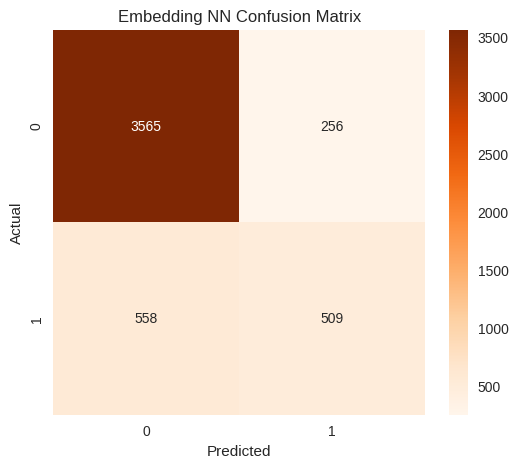

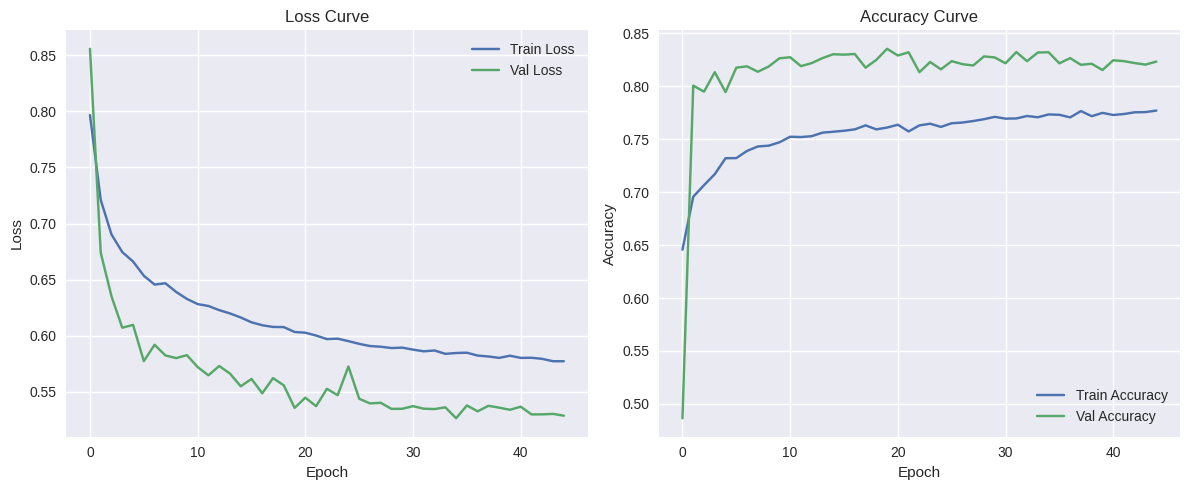

In [ ]:




# ============================================================
# 5️⃣ Evaluasi
# ============================================================

y_pred_embed = np.argmax(embedding_model.predict(X_test_embed), axis=1)

print("Embedding NN Classification Report:")
print(classification_report(y_test, y_pred_embed, target_names=["0","1"]))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_embed), annot=True, fmt="d", cmap="Oranges")
plt.title("Embedding NN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot Loss & Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_embed.history["loss"], label="Train Loss")
plt.plot(history_embed.history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history_embed.history["accuracy"], label="Train Accuracy")
plt.plot(history_embed.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Save model

In [ ]:
import os
import shutil
from google.colab import files

# ============================================================
# 1. Simpan dalam format native Keras (.keras) ← PALING DIREKOMENDASIKAN
# ============================================================
keras_path = "/content/embedding_model.keras"
embedding_model.save(keras_path)
print(f"Model berhasil disimpan (.keras): {keras_path}")

# ============================================================
# 2. Simpan dalam format HDF5 (.h5) ← untuk kompatibilitas lama (ada warning, tapi works)
# ============================================================
h5_path = "/content/embedding_model.h5"
embedding_model.save(h5_path)
print(f"Model berhasil disimpan (.h5): {h5_path}")
# Warning di sini normal, abaikan saja jika tidak butuh .h5

# ============================================================
# 3. Simpan dalam format SavedModel (untuk TF Serving / inference ringan)
#    Gunakan model.export() di Keras 3+
# ============================================================
savedmodel_path = "/content/embedding_model_savedmodel"
embedding_model.export(savedmodel_path)
print(f"Model SavedModel berhasil diexport ke folder: {savedmodel_path}")

# ============================================================
# 4. Zip folder SavedModel agar mudah download
# ============================================================
zip_savedmodel = "/content/embedding_model_savedmodel.zip"
shutil.make_archive(base_name="embedding_model_savedmodel", format="zip", root_dir="embedding_model_savedmodel")
print(f"Folder SavedModel di-zip: {zip_savedmodel}")

# ============================================================
# 5. Download semua file
# ============================================================
print("\nMulai download file-file model...")

files.download(keras_path)          # Format terbaik untuk Streamlit
files.download(h5_path)             # Jika butuh kompatibilitas lama
files.download(zip_savedmodel)      # SavedModel (untuk TF Serving, dll.)

print("\nSemua file selesai didownload!")

Model berhasil disimpan (.keras): /content/embedding_model.keras
Model berhasil disimpan (.h5): /content/embedding_model.h5
Saved artifact at '/content/embedding_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 1), dtype=tf.float32, name='person_home_ownership_input'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='loan_intent_input'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='loan_grade_input'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='cb_person_default_on_file_input'), TensorSpec(shape=(None, 7), dtype=tf.float32, name='numerical_input')]
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132652601185808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132652601186192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132652601188688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132652601188112: TensorSpec(shape=(), dtype=tf.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Semua file selesai didownload!


## 🔵 Implementasi Model FT-Transformer

### Convert to torch tensor

In [ ]:
# ============================================================
# CONVERT TO TORCH TENSORS
# ============================================================

device = "cuda" if torch.cuda.is_available() else "cpu"

X_train_num = torch.tensor(X_train_ft[num_cols].values, dtype=torch.float32).to(device)
X_val_num   = torch.tensor(X_val_ft[num_cols].values,   dtype=torch.float32).to(device)
X_test_num  = torch.tensor(X_test_ft[num_cols].values,  dtype=torch.float32).to(device)

X_train_cat = torch.tensor(X_train_ft[cat_cols].values, dtype=torch.long).to(device)
X_val_cat   = torch.tensor(X_val_ft[cat_cols].values,   dtype=torch.long).to(device)
X_test_cat  = torch.tensor(X_test_ft[cat_cols].values,  dtype=torch.long).to(device)

y_train_t = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_val_t   = torch.tensor(y_val.values,   dtype=torch.long).to(device)
y_test_t  = torch.tensor(y_test.values,  dtype=torch.long).to(device)


print("X_train_num:", X_train_num.shape)
print("X_train_cat:", X_train_cat.shape)
print("y_train    :", y_train_t.shape)



X_train_num: torch.Size([22806, 7])
X_train_cat: torch.Size([22806, 4])
y_train    : torch.Size([22806])


### Build model

In [ ]:
cat_cardinalities = [
    len(cat_encoders[col].classes_)
    for col in cat_cols
]


In [ ]:
# ============================================================
# FT-TRANSFORMER MODEL (FINAL FIX)
# ============================================================

from rtdl_revisiting_models import FTTransformer



model = FTTransformer(
    n_cont_features=len(num_cols),
    cat_cardinalities=cat_cardinalities,

    d_block=32,
    n_blocks=4,
    attention_n_heads=8,

    attention_dropout=0.1,
    ffn_d_hidden_multiplier=4/3,
    ffn_dropout=0.1,
    residual_dropout=0.1,

    d_out=num_classes
).to(device)

### Train model

In [ ]:
# from sklearn.base import BaseEstimator, TransformerMixin
# import numpy as np
# import pandas as pd

# class FTPreprocessor(BaseEstimator, TransformerMixin):
#     def __init__(self, num_cols, cat_cols, scaler, cat_encoders):
#         self.num_cols = num_cols
#         self.cat_cols = cat_cols
#         self.scaler = scaler
#         self.cat_encoders = cat_encoders

#     def fit(self, X, y=None):
#         return self  # sudah fit di training

#     def transform(self, X):
#         X = X.copy()

#         # categorical
#         for col in self.cat_cols:
#             X[col] = self.cat_encoders[col].transform(X[col].astype(str))

#         # numerical
#         X_num = self.scaler.transform(X[self.num_cols])

#         # gabung: num dulu, lalu cat
#         X_cat = X[self.cat_cols].values
#         return np.hstack([X_num, X_cat])


In [ ]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)

criterion = nn.CrossEntropyLoss()

In [ ]:
import copy


best_state = None
best_val_loss = float("inf")
patience = 7
counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(500):

    # ===== TRAIN =====
    model.train()
    optimizer.zero_grad()

    out = model(X_train_num, X_train_cat)
    loss = criterion(out, y_train_t)
    loss.backward()
    optimizer.step()

    train_acc = (out.argmax(1) == y_train_t).float().mean().item()

    # ===== VALID =====
    model.eval()
    with torch.no_grad():
        val_out = model(X_val_num, X_val_cat)
        val_loss = criterion(val_out, y_val_t)
        val_acc = (val_out.argmax(1) == y_val_t).float().mean().item()

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch+1:03d} | "
        f"Train Loss {loss.item():.4f} Acc {train_acc:.4f} | "
        f"Val Loss {val_loss.item():.4f} Acc {val_acc:.4f}"
    )

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("🛑 Early stopping")
        break

model.load_state_dict(best_state)
model.eval()


Epoch 001 | Train Loss 0.5665 Acc 0.7748 | Val Loss 0.5272 Acc 0.7819
Epoch 002 | Train Loss 0.5260 Acc 0.7819 | Val Loss 0.5249 Acc 0.7819
Epoch 003 | Train Loss 0.5224 Acc 0.7819 | Val Loss 0.5113 Acc 0.7819
Epoch 004 | Train Loss 0.5131 Acc 0.7819 | Val Loss 0.4982 Acc 0.7819
Epoch 005 | Train Loss 0.5039 Acc 0.7819 | Val Loss 0.4895 Acc 0.7819
Epoch 006 | Train Loss 0.4972 Acc 0.7819 | Val Loss 0.4779 Acc 0.7819
Epoch 007 | Train Loss 0.4892 Acc 0.7819 | Val Loss 0.4606 Acc 0.7819
Epoch 008 | Train Loss 0.4765 Acc 0.7819 | Val Loss 0.4458 Acc 0.7819
Epoch 009 | Train Loss 0.4627 Acc 0.7819 | Val Loss 0.4331 Acc 0.7835
Epoch 010 | Train Loss 0.4514 Acc 0.7826 | Val Loss 0.4152 Acc 0.8009
Epoch 011 | Train Loss 0.4344 Acc 0.7901 | Val Loss 0.4014 Acc 0.8275
Epoch 012 | Train Loss 0.4231 Acc 0.8094 | Val Loss 0.3984 Acc 0.8293
Epoch 013 | Train Loss 0.4159 Acc 0.8149 | Val Loss 0.3931 Acc 0.8308
Epoch 014 | Train Loss 0.4086 Acc 0.8184 | Val Loss 0.3930 Acc 0.8369
Epoch 015 | Train Lo

FTTransformer(
  (cls_embedding): _CLSEmbedding()
  (cont_embeddings): LinearEmbeddings()
  (cat_embeddings): CategoricalEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(4, 32)
      (1): Embedding(6, 32)
      (2): Embedding(7, 32)
      (3): Embedding(2, 32)
    )
  )
  (backbone): FTTransformerBackbone(
    (blocks): ModuleList(
      (0): ModuleDict(
        (attention): MultiheadAttention(
          (W_q): Linear(in_features=32, out_features=32, bias=True)
          (W_k): Linear(in_features=32, out_features=32, bias=True)
          (W_v): Linear(in_features=32, out_features=32, bias=True)
          (W_out): Linear(in_features=32, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (attention_residual_dropout): Dropout(p=0.1, inplace=False)
        (ffn_normalization): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (linear1): Linear(in_features=32, out_features=84, bias=True)
    

### Evaluasi model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import numpy as np

model.eval()

with torch.no_grad():
    logits = model(X_test_num, X_test_cat)
    probs = torch.softmax(logits, dim=1)

    y_pred = logits.argmax(dim=1).cpu().numpy()
    y_prob = probs[:, 1].cpu().numpy()
    y_true = y_test_t.cpu().numpy()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("ROC-AUC :", roc_auc_score(y_true, y_prob))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
cm


Accuracy: 0.931873977086743
ROC-AUC : 0.9252687081479134

Classification Report:

              precision    recall  f1-score   support

           0     0.9254    0.9929    0.9580      3821
           1     0.9657    0.7132    0.8205      1067

    accuracy                         0.9319      4888
   macro avg     0.9456    0.8531    0.8892      4888
weighted avg     0.9342    0.9319    0.9280      4888



array([[3794,   27],
       [ 306,  761]])

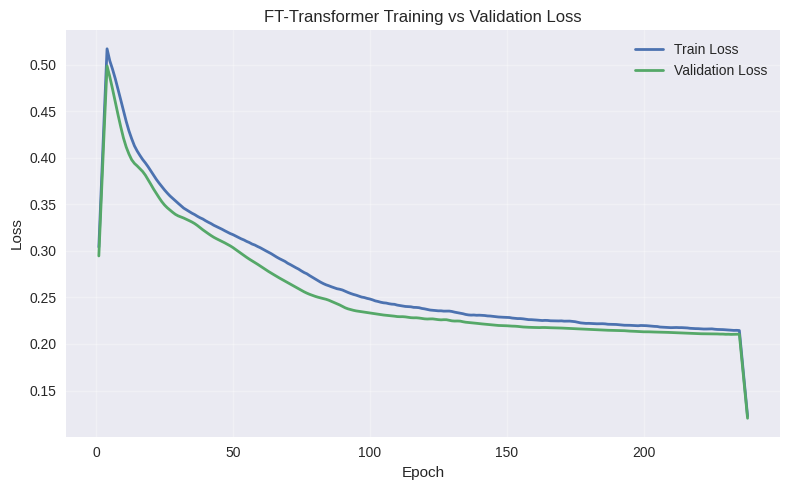

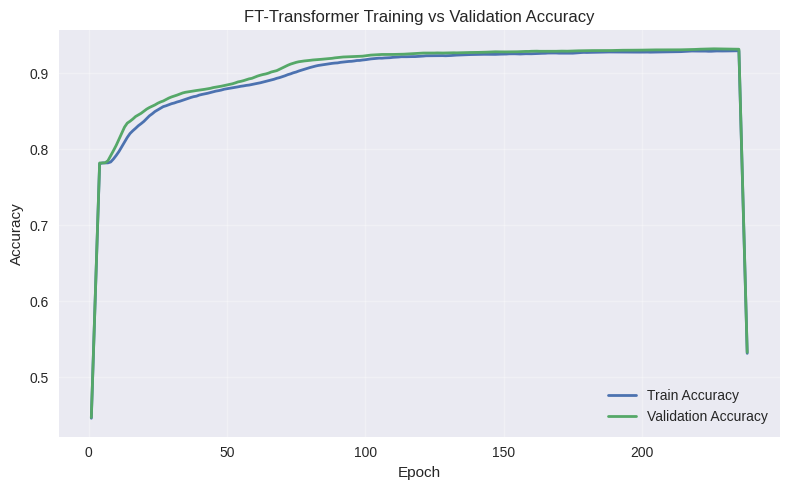

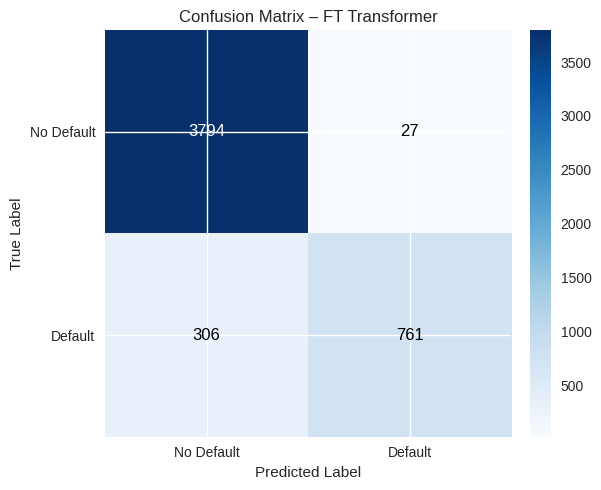

In [ ]:
import numpy as np

def smooth_curve(values, window=7):
    if len(values) < window:
        return np.array(values)
    kernel = np.ones(window) / window
    return np.convolve(values, kernel, mode="same")

import matplotlib.pyplot as plt

epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, smooth_curve(train_losses), label="Train Loss", linewidth=2)
plt.plot(epochs, smooth_curve(val_losses), label="Validation Loss", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("FT-Transformer Training vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, smooth_curve(train_accs), label="Train Accuracy", linewidth=2)
plt.plot(epochs, smooth_curve(val_accs), label="Validation Accuracy", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("FT-Transformer Training vs Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

class_names = ["No Default", "Default"]  # sesuaikan labelmu

plt.figure(figsize=(6, 5))
im = plt.imshow(cm, cmap="Blues")

plt.colorbar(im, fraction=0.046, pad=0.04)

plt.xticks(np.arange(len(class_names)), class_names)
plt.yticks(np.arange(len(class_names)), class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – FT Transformer")

# angka di dalam kotak
threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > threshold else "black",
            fontsize=12
        )

plt.tight_layout()
plt.show()



### Save model

In [ ]:
import torch
import os
import pickle
import joblib
SAVE_DIR = "/content/ft_transformer_model2"
os.makedirs(SAVE_DIR, exist_ok=True)

torch.save(
    model.state_dict(),
    f"{SAVE_DIR}/model.pt"
)

print("✅ Model weights saved")




# ft_preprocessor = FTPreprocessor(
#     num_cols=num_cols,
#     cat_cols=cat_cols,
#     scaler=scaler,
#     cat_encoders=cat_encoders
# )



joblib.dump(scaler, f"{SAVE_DIR}/scaler.pkl")
joblib.dump(cat_encoders, f"{SAVE_DIR}/cat_encoders.pkl")
joblib.dump(num_cols, f"{SAVE_DIR}/num_cols.pkl")
joblib.dump(cat_cols, f"{SAVE_DIR}/cat_cols.pkl")

print("✅ Preprocessing objects saved (SAFE FOR STREAMLIT)")


print("✅ FT preprocessing pipeline saved")



print("✅ Preprocessing objects saved")

config = {
    "numerical_features": numerical_features,
    "categorical_features": categorical_features,
    "cat_cardinalities": cat_cardinalities,
    "d_block": 32,
    "n_blocks": 4,
    "attention_n_heads": 8,
    "ffn_d_hidden_multiplier": 4 / 3,
    "attention_dropout": 0.1,
    "ffn_dropout": 0.1,
    "residual_dropout": 0.1,
    "num_classes": 2
}

joblib.dump(
    config,
    f"{SAVE_DIR}/config.pkl"
)

print("✅ Config saved")


✅ Model weights saved
✅ Preprocessing objects saved (SAFE FOR STREAMLIT)
✅ FT preprocessing pipeline saved
✅ Preprocessing objects saved
✅ Config saved


In [ ]:
!zip -r ft_transformer_model2.zip ft_transformer_model2


  adding: ft_transformer_model2/ (stored 0%)
  adding: ft_transformer_model2/model.pt (deflated 17%)
  adding: ft_transformer_model2/config.pkl (deflated 40%)
  adding: ft_transformer_model2/cat_encoders.pkl (deflated 57%)
  adding: ft_transformer_model2/scaler.pkl (deflated 22%)
  adding: ft_transformer_model2/num_cols.pkl (deflated 29%)
  adding: ft_transformer_model2/cat_cols.pkl (deflated 14%)
